Starting hourly pattern analysis...


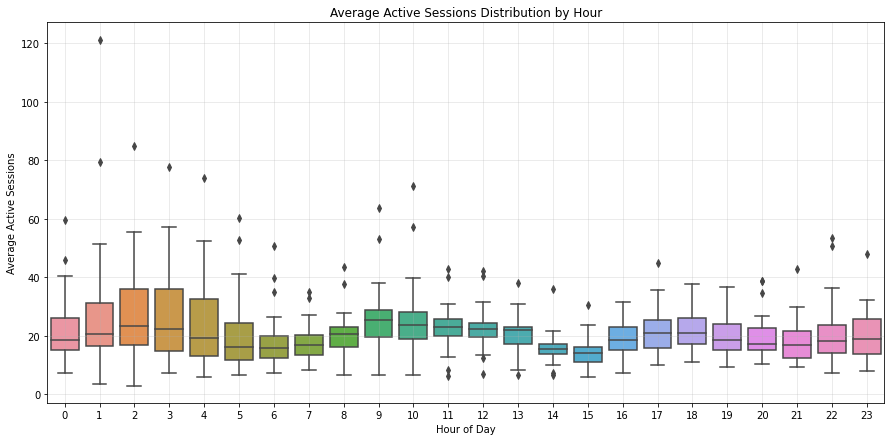

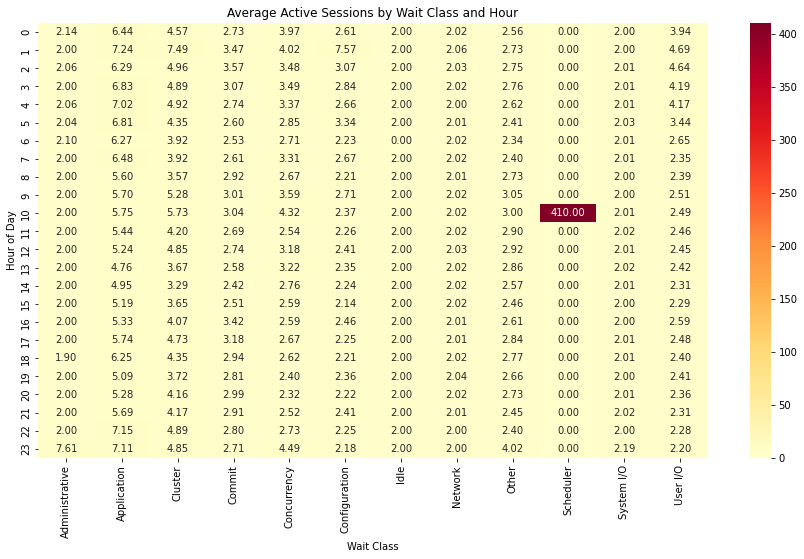

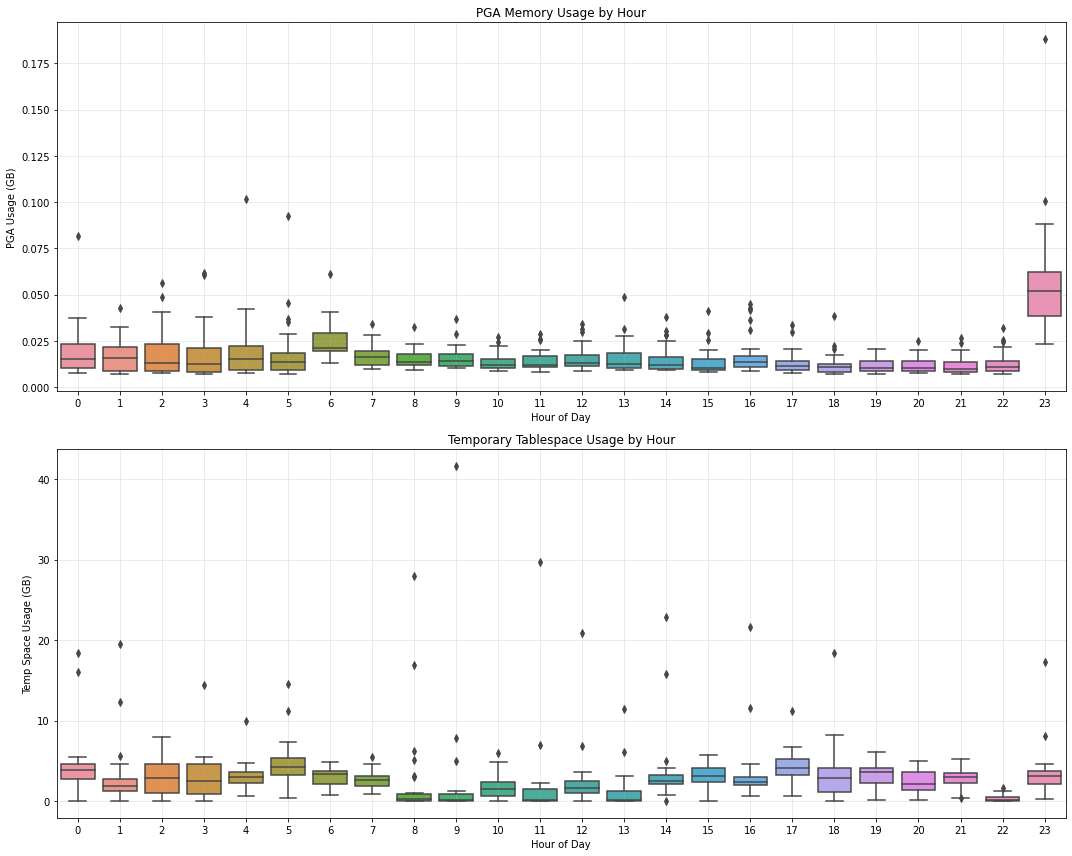


Hourly Workload Analysis Summary

Analysis Period: 31 days
From: 2025-01-12T18:08:54.750000
To: 2025-02-11T18:05:07.252000

Peak Hours (Top 5):
- Hour 01:00
  * Average Active Sessions: 28.77
  * Peak Active Sessions: 121.33
  * Average Samples: 1070.9
- Hour 02:00
  * Average Active Sessions: 27.56
  * Peak Active Sessions: 84.79
  * Average Samples: 1072.4
- Hour 03:00
  * Average Active Sessions: 27.02
  * Peak Active Sessions: 77.79
  * Average Samples: 1074.2
- Hour 09:00
  * Average Active Sessions: 25.80
  * Peak Active Sessions: 63.66
  * Average Samples: 1076.2
- Hour 10:00
  * Average Active Sessions: 25.29
  * Peak Active Sessions: 71.11
  * Average Samples: 1074.1

Quiet Hours (Top 5):
- Hour 15:00
  * Average Active Sessions: 14.41
  * Peak Active Sessions: 30.60
  * Average Samples: 1072.1
- Hour 14:00
  * Average Active Sessions: 15.79
  * Peak Active Sessions: 35.92
  * Average Samples: 1071.2
- Hour 07:00
  * Average Active Sessions: 17.49
  * Peak Active Sessions: 35

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime, timedelta
from config import get_pdb_directories, ensure_directories_exist

class HourlyPatternAnalyzer:
    def __init__(self, data_file):
        """Initialize the analyzer with ASH data"""
        self.df = pd.read_csv(f"{data_file}.gz", compression='gzip')
        self.df['sample_time'] = pd.to_datetime(self.df['sample_time'])
        
        # Setup directories
        paths = get_pdb_directories()
        self.analysis_dir = os.path.join(paths['awr_data_dir'], 'hourly_analysis')
        self.viz_dir = os.path.join(self.analysis_dir, 'visualizations')
        os.makedirs(self.viz_dir, exist_ok=True)

    def save_plot(self, name, dpi=300):
        """Save the current plot with high resolution"""
        plt.savefig(os.path.join(self.viz_dir, f'{name}.png'), dpi=dpi, bbox_inches='tight')
        plt.close()

    def analyze_hourly_patterns(self):
        """Analyze hourly workload patterns"""
        # Extract hour and date from sample_time
        self.df['hour'] = self.df['sample_time'].dt.hour
        self.df['date'] = self.df['sample_time'].dt.date
        
        # Count samples per hour
        sample_counts = self.df.groupby(['date', 'hour'])['sample_time'].nunique().reset_index()
        sample_counts.columns = ['date', 'hour', 'sample_count']
        
        # Calculate metrics for each hour - using separate aggregations to avoid MultiIndex
        hourly_sessions = self.df.groupby(['date', 'hour'])['session_count'].sum().reset_index()
        hourly_instances = self.df.groupby(['date', 'hour'])['instance_number'].nunique().reset_index()
        hourly_pga = self.df.groupby(['date', 'hour'])['pga_allocated'].agg(['mean', 'max']).reset_index()
        hourly_temp = self.df.groupby(['date', 'hour'])['temp_space_allocated'].agg(['mean', 'max']).reset_index()
        
        # Merge all metrics
        hourly_metrics = hourly_sessions.merge(hourly_instances, on=['date', 'hour'])
        hourly_metrics = hourly_metrics.merge(hourly_pga, on=['date', 'hour'])
        hourly_metrics = hourly_metrics.merge(hourly_temp, on=['date', 'hour'])
        hourly_metrics = hourly_metrics.merge(sample_counts, on=['date', 'hour'])
        
        # Calculate AAS (Average Active Sessions)
        # AAS = total_sessions / number_of_samples
        hourly_metrics['aas'] = hourly_metrics['session_count'] / hourly_metrics['sample_count']
        
        # Convert memory metrics to GB
        hourly_metrics['pga_gb'] = hourly_metrics['mean_x'] / 1024 / 1024 / 1024
        hourly_metrics['pga_max_gb'] = hourly_metrics['max_x'] / 1024 / 1024 / 1024
        hourly_metrics['temp_space_gb'] = hourly_metrics['mean_y'] / 1024 / 1024 / 1024
        hourly_metrics['temp_space_max_gb'] = hourly_metrics['max_y'] / 1024 / 1024 / 1024
        
        return hourly_metrics

    def analyze_wait_class_patterns(self):
        """Analyze wait class patterns by hour"""
        self.df['hour'] = self.df['sample_time'].dt.hour
        self.df['date'] = self.df['sample_time'].dt.date
        
        # Count samples per hour and wait class
        sample_counts = self.df.groupby(['date', 'hour', 'wait_class'])['sample_time'].nunique().reset_index()
        sample_counts.columns = ['date', 'hour', 'wait_class', 'sample_count']
        
        # Group by hour and wait_class - using separate aggregations
        wait_sessions = self.df.groupby(['date', 'hour', 'wait_class'])['session_count'].sum().reset_index()
        wait_pga = self.df.groupby(['date', 'hour', 'wait_class'])['pga_allocated'].agg(['mean', 'max']).reset_index()
        wait_temp = self.df.groupby(['date', 'hour', 'wait_class'])['temp_space_allocated'].agg(['mean', 'max']).reset_index()
        
        # Merge metrics
        wait_metrics = wait_sessions.merge(wait_pga, on=['date', 'hour', 'wait_class'])
        wait_metrics = wait_metrics.merge(wait_temp, on=['date', 'hour', 'wait_class'])
        wait_metrics = wait_metrics.merge(sample_counts, on=['date', 'hour', 'wait_class'])
        
        # Calculate AAS per wait class
        wait_metrics['aas'] = wait_metrics['session_count'] / wait_metrics['sample_count']
        
        # Calculate average AAS by hour and wait class across all days
        avg_wait_by_hour = wait_metrics.groupby(['hour', 'wait_class'])['aas'].mean().reset_index()
        
        # Pivot for heatmap
        wait_heatmap = avg_wait_by_hour.pivot(
            index='hour',
            columns='wait_class',
            values='aas'
        ).fillna(0)
        
        return wait_metrics, wait_heatmap

    def generate_report(self):
        """Generate comprehensive hourly analysis report"""
        # Get hourly patterns
        hourly_metrics = self.analyze_hourly_patterns()
        wait_metrics, wait_heatmap = self.analyze_wait_class_patterns()
        
        # Calculate average metrics by hour across all days
        avg_by_hour = hourly_metrics.groupby('hour').agg({
            'aas': ['mean', 'std', 'min', 'max'],
            'instance_number': 'mean',
            'pga_gb': ['mean', 'max'],
            'temp_space_gb': ['mean', 'max'],
            'sample_count': 'mean'  # Add sample count to the report
        })

        # Create visualizations
        # 1. Average Active Sessions by Hour
        plt.figure(figsize=(15, 7))
        sns.boxplot(data=hourly_metrics, x='hour', y='aas')
        plt.title('Average Active Sessions Distribution by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Active Sessions')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 2. Wait Class Heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(wait_heatmap, cmap='YlOrRd', annot=True, fmt='.2f')
        plt.title('Average Active Sessions by Wait Class and Hour')
        plt.xlabel('Wait Class')
        plt.ylabel('Hour of Day')
        plt.show()

        # 3. Resource Usage by Hour
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Memory (PGA) Usage
        sns.boxplot(data=hourly_metrics, x='hour', y='pga_gb', ax=ax1)
        ax1.set_title('PGA Memory Usage by Hour')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('PGA Usage (GB)')
        ax1.grid(True, alpha=0.3)
        
        # Temp Space Usage
        sns.boxplot(data=hourly_metrics, x='hour', y='temp_space_gb', ax=ax2)
        ax2.set_title('Temporary Tablespace Usage by Hour')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Temp Space Usage (GB)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        # Prepare report data
        report = {
            'analysis_period': {
                'start': self.df['sample_time'].min().isoformat(),
                'end': self.df['sample_time'].max().isoformat(),
                'total_days': len(self.df['date'].unique())
            },
            'hourly_patterns': {
                'by_hour': [
                    {
                        'hour': hour,
                        'active_sessions': {
                            'mean': float(stats['aas']['mean']),
                            'std': float(stats['aas']['std']),
                            'min': float(stats['aas']['min']),
                            'max': float(stats['aas']['max'])
                        },
                        'resource_usage': {
                            'memory': {
                                'avg_pga_gb': float(stats['pga_gb']['mean']),
                                'max_pga_gb': float(stats['pga_gb']['max'])
                            },
                            'disk': {
                                'avg_temp_gb': float(stats['temp_space_gb']['mean']),
                                'max_temp_gb': float(stats['temp_space_gb']['max'])
                            }
                        },
                        'instances': float(stats['instance_number']),
                        'avg_samples': float(stats['sample_count']['mean'])
                    }
                    for hour, stats in avg_by_hour.iterrows()
                ]
            },
            'peak_hours': sorted(
                [
                    {
                        'hour': hour,
                        'average_active_sessions': float(stats['aas']['mean']),
                        'peak_active_sessions': float(stats['aas']['max']),
                        'avg_samples': float(stats['sample_count']['mean'])
                    }
                    for hour, stats in avg_by_hour.iterrows()
                ],
                key=lambda x: x['average_active_sessions'],
                reverse=True
            )[:5],
            'quiet_hours': sorted(
                [
                    {
                        'hour': hour,
                        'average_active_sessions': float(stats['aas']['mean']),
                        'peak_active_sessions': float(stats['aas']['max']),
                        'avg_samples': float(stats['sample_count']['mean'])
                    }
                    for hour, stats in avg_by_hour.iterrows()
                ],
                key=lambda x: x['average_active_sessions']
            )[:5]
        }

        # Save detailed report
        output_file = os.path.join(self.analysis_dir, 'hourly_analysis.json')
        with open(output_file, 'w') as f:
            json.dump(report, f, indent=2)

        return report

def main():
    try:
        print("Starting hourly pattern analysis...")
        
        paths = get_pdb_directories()
        ensure_directories_exist(paths)
        
        analyzer = HourlyPatternAnalyzer(paths['historical_data_file'])
        report = analyzer.generate_report()
        
        # Print business-focused summary
        print("\nHourly Workload Analysis Summary")
        print("=" * 50)
        
        print(f"\nAnalysis Period: {report['analysis_period']['total_days']} days")
        print(f"From: {report['analysis_period']['start']}")
        print(f"To: {report['analysis_period']['end']}")
        
        print("\nPeak Hours (Top 5):")
        for peak in report['peak_hours']:
            print(f"- Hour {peak['hour']:02d}:00")
            print(f"  * Average Active Sessions: {peak['average_active_sessions']:.2f}")
            print(f"  * Peak Active Sessions: {peak['peak_active_sessions']:.2f}")
            print(f"  * Average Samples: {peak['avg_samples']:.1f}")
        
        print("\nQuiet Hours (Top 5):")
        for quiet in report['quiet_hours']:
            print(f"- Hour {quiet['hour']:02d}:00")
            print(f"  * Average Active Sessions: {quiet['average_active_sessions']:.2f}")
            print(f"  * Peak Active Sessions: {quiet['peak_active_sessions']:.2f}")
            print(f"  * Average Samples: {quiet['avg_samples']:.1f}")
        
        print("\nDetailed Analysis Files:")
        print(f"- Full report: {os.path.join(analyzer.analysis_dir, 'hourly_analysis.json')}")
        print(f"- Visualizations: {analyzer.viz_dir}")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
from config import get_pdb_directories, ensure_directories_exist

class OutlierAnalyzer:
    def __init__(self, data_file):
        """Initialize the analyzer with ASH data"""
        print("Loading data...")
        self.data_file = data_file
        
        # Setup directories
        paths = get_pdb_directories()
        self.analysis_dir = os.path.join(paths['awr_data_dir'], 'outlier_analysis')
        os.makedirs(self.analysis_dir, exist_ok=True)

    def process_chunk(self, chunk):
        """Process a single chunk of data"""
        # Convert sample_time to datetime and extract components
        chunk['sample_time'] = pd.to_datetime(chunk['sample_time'])
        chunk['hour'] = chunk['sample_time'].dt.hour
        chunk['date'] = chunk['sample_time'].dt.strftime('%Y-%m-%d')
        return chunk

    def analyze_hourly_outliers(self):
        """Analyze outlier sessions by hour"""
        print("Processing data in chunks...")
        
        # Initialize storage for metrics
        hourly_stats = {hour: {
            'session_counts': [],
            'pga_allocated': [],
            'temp_space_allocated': [],
            'instance_counts': [],
            'wait_classes': {},
            'events': {},
            'sql_ids': {},
            'modules': {}
        } for hour in range(24)}
        
        # Process data in smaller chunks
        chunk_size = 50000  # Reduced chunk size
        
        for chunk in pd.read_csv(
            f"{self.data_file}.gz",
            compression='gzip',
            usecols=[
                'sample_time', 'session_count', 'instance_number',
                'wait_class', 'event', 'sql_id', 'module',
                'pga_allocated', 'temp_space_allocated'
            ],
            dtype={
                'session_count': 'float32',
                'instance_number': 'int32',
                'wait_class': 'category',
                'event': 'category',
                'sql_id': 'category',
                'module': 'category',
                'pga_allocated': 'float32',
                'temp_space_allocated': 'float32'
            },
            chunksize=chunk_size
        ):
            # Process chunk
            chunk = self.process_chunk(chunk)
            
            # Process each hour separately
            for hour in range(24):
                hour_data = chunk[chunk['hour'] == hour]
                if hour_data.empty:
                    continue
                
                # Group by sample time for this hour
                sample_metrics = hour_data.groupby('sample_time').agg({
                    'session_count': 'sum',
                    'instance_number': 'nunique',
                    'pga_allocated': ['mean', 'max'],
                    'temp_space_allocated': ['mean', 'max']
                }).reset_index()
                
                # Update hourly statistics
                hourly_stats[hour]['session_counts'].extend(sample_metrics['session_count'].values)
                hourly_stats[hour]['instance_counts'].extend([sample_metrics['instance_number'].values[0]])
                hourly_stats[hour]['pga_allocated'].extend(sample_metrics['pga_allocated']['mean'].values)
                hourly_stats[hour]['temp_space_allocated'].extend(sample_metrics['temp_space_allocated']['mean'].values)
                
                # Update wait class statistics
                wait_counts = hour_data.groupby('wait_class')['session_count'].sum()
                for wait_class, count in wait_counts.items():
                    if wait_class not in hourly_stats[hour]['wait_classes']:
                        hourly_stats[hour]['wait_classes'][wait_class] = 0
                    hourly_stats[hour]['wait_classes'][wait_class] += float(count)
                
                # Update event statistics
                event_counts = hour_data.groupby('event')['session_count'].sum()
                for event, count in event_counts.items():
                    if event not in hourly_stats[hour]['events']:
                        hourly_stats[hour]['events'][event] = 0
                    hourly_stats[hour]['events'][event] += float(count)
                
                # Update SQL ID statistics
                sql_counts = hour_data.groupby('sql_id')['session_count'].sum()
                for sql_id, count in sql_counts.items():
                    if sql_id not in hourly_stats[hour]['sql_ids']:
                        hourly_stats[hour]['sql_ids'][sql_id] = 0
                    hourly_stats[hour]['sql_ids'][sql_id] += float(count)
                
                # Update module statistics
                module_counts = hour_data.groupby('module')['session_count'].sum()
                for module, count in module_counts.items():
                    if module not in hourly_stats[hour]['modules']:
                        hourly_stats[hour]['modules'][module] = 0
                    hourly_stats[hour]['modules'][module] += float(count)
            
            # Clear chunk from memory
            del chunk
        
        # Process outliers by hour
        print("Analyzing outliers by hour...")
        outliers = {}
        
        for hour in range(24):
            print(f"Processing hour {hour:02d}...")
            
            if not hourly_stats[hour]['session_counts']:
                continue
            
            # Calculate statistics
            session_counts = np.array(hourly_stats[hour]['session_counts'])
            Q1 = np.percentile(session_counts, 25)
            Q3 = np.percentile(session_counts, 75)
            IQR = Q3 - Q1
            
            # Define outlier thresholds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outlier_indices = np.where((session_counts < lower_bound) | (session_counts > upper_bound))[0]
            
            if len(outlier_indices) > 0:
                # Get top statistics
                top_wait_classes = dict(sorted(
                    hourly_stats[hour]['wait_classes'].items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5])
                
                top_events = dict(sorted(
                    hourly_stats[hour]['events'].items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5])
                
                top_sql_ids = dict(sorted(
                    hourly_stats[hour]['sql_ids'].items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5])
                
                outliers[hour] = {
                    'thresholds': {
                        'lower': float(lower_bound),
                        'upper': float(upper_bound),
                        'q1': float(Q1),
                        'q3': float(Q3),
                        'iqr': float(IQR)
                    },
                    'statistics': {
                        'wait_classes': top_wait_classes,
                        'events': top_events,
                        'sql_ids': top_sql_ids,
                        'avg_sessions': float(np.mean(session_counts)),
                        'max_sessions': float(np.max(session_counts)),
                        'avg_pga_gb': float(np.mean(hourly_stats[hour]['pga_allocated']) / (1024 * 1024 * 1024)),
                        'avg_temp_gb': float(np.mean(hourly_stats[hour]['temp_space_allocated']) / (1024 * 1024 * 1024))
                    }
                }
        
        return outliers

    def generate_report(self):
        """Generate comprehensive outlier analysis report"""
        print("Generating report...")
        outliers = self.analyze_hourly_outliers()
        
        # Get analysis period from first and last chunks
        first_chunk = next(pd.read_csv(
            f"{self.data_file}.gz",
            compression='gzip',
            usecols=['sample_time'],
            chunksize=1
        ))
        first_chunk['sample_time'] = pd.to_datetime(first_chunk['sample_time'])
        start_time = first_chunk['sample_time'].min()
        
        # Get end time from last chunk
        for chunk in pd.read_csv(
            f"{self.data_file}.gz",
            compression='gzip',
            usecols=['sample_time'],
            chunksize=1000
        ):
            chunk['sample_time'] = pd.to_datetime(chunk['sample_time'])
            end_time = chunk['sample_time'].max()
        
        report = {
            'analysis_period': {
                'start': start_time.isoformat(),
                'end': end_time.isoformat(),
                'total_days': (end_time - start_time).days + 1
            },
            'hourly_outliers': outliers
        }
        
        # Save detailed report
        output_file = os.path.join(self.analysis_dir, 'outlier_analysis.json')
        print(f"Saving report to {output_file}")
        with open(output_file, 'w') as f:
            json.dump(report, f, indent=2)
            
        return report

def main():
    try:
        print("Starting outlier analysis...")
        
        paths = get_pdb_directories()
        ensure_directories_exist(paths)
        
        analyzer = OutlierAnalyzer(paths['historical_data_file'])
        report = analyzer.generate_report()
        
        # Print business-focused summary
        print("\nOutlier Analysis Summary")
        print("=" * 50)
        
        print(f"\nAnalysis Period: {report['analysis_period']['total_days']} days")
        print(f"From: {report['analysis_period']['start']}")
        print(f"To: {report['analysis_period']['end']}")
        
        for hour, data in report['hourly_outliers'].items():
            print(f"\nHour {hour}:00")
            print("-" * 20)
            print(f"Thresholds: ")
            print(f"  - Normal range: {data['thresholds']['lower']:.2f} to {data['thresholds']['upper']:.2f} sessions")
            print(f"  - Q1: {data['thresholds']['q1']:.2f}")
            print(f"  - Q3: {data['thresholds']['q3']:.2f}")
            
            stats = data['statistics']
            print("\nStatistics:")
            print(f"  Average Sessions: {stats['avg_sessions']:.2f}")
            print(f"  Maximum Sessions: {stats['max_sessions']:.2f}")
            print(f"  Average PGA Usage: {stats['avg_pga_gb']:.2f} GB")
            print(f"  Average Temp Space Usage: {stats['avg_temp_gb']:.2f} GB")
            
            if stats['wait_classes']:
                print("\nTop Wait Classes:")
                for wait_class, count in stats['wait_classes'].items():
                    print(f"  - {wait_class}: {count}")
            
            if stats['sql_ids']:
                print("\nTop SQL IDs:")
                for sql_id, count in stats['sql_ids'].items():
                    print(f"  - {sql_id}: {count}")
        
        print(f"\nDetailed analysis saved to: {os.path.join(analyzer.analysis_dir, 'outlier_analysis.json')}")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Starting outlier analysis...
Loading data...
Generating report...
Processing data in chunks...
Analyzing outliers by hour...
Processing hour 00...
Processing hour 01...
Processing hour 02...
Processing hour 03...
Processing hour 04...
Processing hour 05...
Processing hour 06...
Processing hour 07...
Processing hour 08...
Processing hour 09...
Processing hour 10...
Processing hour 11...
Processing hour 12...
Processing hour 13...
Processing hour 14...
Processing hour 15...
Processing hour 16...
Processing hour 17...
Processing hour 18...
Processing hour 19...
Processing hour 20...
Processing hour 21...
Processing hour 22...
Processing hour 23...
Saving report to database_analysis/BDGLAUCO/awr_data/outlier_analysis/outlier_analysis.json

Outlier Analysis Summary

Analysis Period: 30 days
From: 2025-01-12T18:08:54.750000
To: 2025-02-11T18:05:07.252000

Hour 0:00
--------------------
Thresholds: 
  - Normal range: -12.00 to 52.00 sessions
  - Q1: 12.00
  - Q3: 28.00

Statistics:
  Average 